In [1]:
import torch 
import matplotlib.pyplot as plt
import numpy as np

from utils import retrieve_setup, retrieve_training_params, training_loop

/Users/juangarcia/anaconda3/envs/ada/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/juangarcia/anaconda3/envs/ada/lib/python3.9/site-packages/torchvision/image.so, 6): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: /Users/juangarcia/anaconda3/envs/ada/lib/python3.9/site-packages/torchvision/image.so
  Expected in: /Users/juangarcia/anaconda3/envs/ada/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
 in /Users/juangarcia/anaconda3/envs/ada/lib/python3.9/site-packages/torchvision/image.so'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/juangarcia/anaconda3/envs/ada/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Define Learning Rate Schedulers to experiment
model, dataset = retrieve_setup("MobileNetV3Small", "CIFAR10")
dataset_name = dataset["train"].root.split("/")[-1]
_, lr_schedulers, _, _, _ = retrieve_training_params(model, dataset_name)

# Removed as only requried to initialize the lr schedulers
del model, dataset, dataset_name

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Experimentation Loop
for scheduler_idx in range(len(lr_schedulers)):
  # Download new model and dataset
  model, dataset = retrieve_setup("MobileNetV3Small", "CIFAR10")
  dataset_name = dataset["train"].root.split("/")[-1]

  # Load all training parameters for new model
  optimizer, lr_scheduler, loss_fn, n_epochs, batch_size = retrieve_training_params(model, dataset_name)
  scheduler_name, scheduler = lr_scheduler[scheduler_idx]

  print(f"Training {model.__class__.__name__} with {scheduler_name} scheduler")
  model_trained, losses = training_loop(
    model, 
    dataset, 
    scheduler, 
    optimizer, 
    loss_fn, 
    n_epochs, 
    batch_size, 
    train_strategy=("iter", 50),
    test_strategy=("iter", 50),
    scheduler_strategy="iter", 
    tensorboard_path=f"./tensorboard/{dataset_name}_{scheduler_name}",
    device=device
  )

Files already downloaded and verified
Files already downloaded and verified
Training MobileNetV3 with FixLR scheduler


KeyboardInterrupt: 

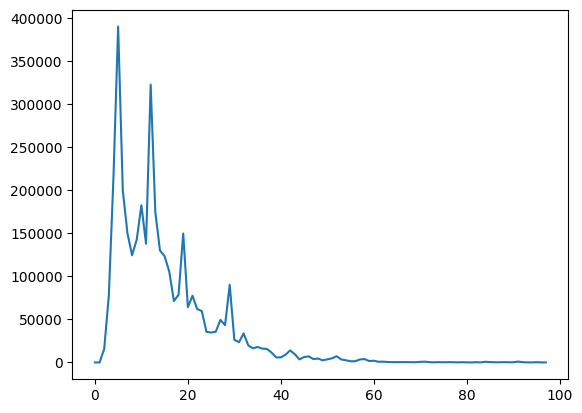

In [4]:
plt.plot(losses)
plt.show()